In [159]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [160]:
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')
df = df.set_index('name') 
df['owner'] = df['owner'].apply(lambda x: 0 if x == "First Owner" else 1).astype(int) 
df['fuel'] = df['fuel'].apply(lambda x: 'Petrol' if x == 'Petrol' else ('Diesel' if x == 'Diesel' else 'Other'))
df = pd.get_dummies(df, columns=['fuel', 'seller_type', 'transmission']) 
df['year'] = 2023 - df['year']
df = df.drop(columns=['transmission_Automatic', 'seller_type_Trustmark Dealer', 'fuel_Other'])
df.columns.values[0] = 'Age'
df['selling_price'] = np.log10(df['selling_price']) 
df['km_driven'] = np.log10(df['km_driven'])
sp = df.pop('selling_price')
df.insert(0, 'selling_price', sp)
bool_columns = ['fuel_Diesel', 'fuel_Petrol', 'seller_type_Dealer', 'seller_type_Individual', 'transmission_Manual']
df[bool_columns] = df[bool_columns].astype(int)
df

,selling_price,Age,km_driven,owner,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,transmission_Manual
name,,,,,,,,,
Maruti 800 AC,4.778151,16,4.845098,0,0,1,0,1,1
Maruti Wagon R LXI Minor,5.130334,16,4.698970,0,0,1,0,1,1
Hyundai Verna 1.6 SX,5.778151,11,5.000000,0,1,0,0,1,1
Datsun RediGO T Option,5.397940,6,4.662758,0,0,1,0,1,1
Honda Amaze VX i-DTEC,5.653213,9,5.149219,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...
Hyundai i20 Magna 1.4 CRDi (Diesel),5.612783,9,4.903090,1,1,0,0,1,1
Hyundai i20 Magna 1.4 CRDi,5.612783,9,4.903090,1,1,0,0,1,1
Maruti 800 AC BSIII,5.041393,14,4.919078,1,0,1,0,1,1


<Axes: xlabel='km_driven', ylabel='selling_price'>

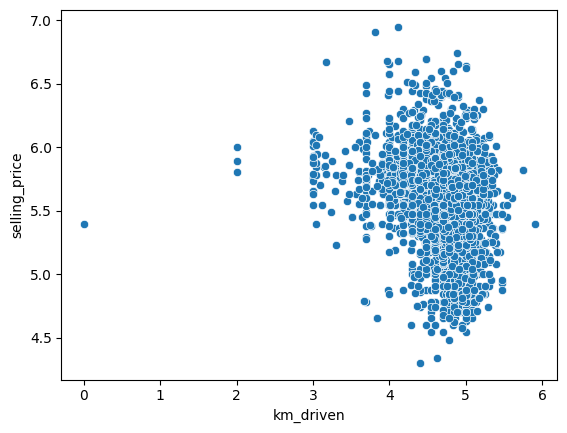

In [161]:
sns.scatterplot(data = df, x = 'km_driven', y = 'selling_price')

In [162]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:],df.iloc[:,0], test_size = .2)

In [163]:
X_train

,Age,km_driven,owner,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,transmission_Manual
name,,,,,,,,
Hyundai Creta 1.6 SX Automatic Diesel,8,4.737463,1,1,0,0,0,0
Honda Amaze E i-VTEC,7,4.698970,1,0,1,0,1,1
Renault KWID Climber 1.0 AMT BSIV,6,3.884115,0,0,1,1,0,0
Hyundai Santro Xing GL Plus,10,4.690196,0,0,1,0,1,1
Maruti Wagon R VXI Optional,8,4.778151,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...
Honda Brio 1.2 S MT,9,4.755875,0,0,1,1,0,1
Maruti Swift DDiS LDI,7,4.732394,0,1,0,1,0,1
Maruti 800 Std,20,4.732394,0,0,1,0,1,1


In [164]:
NN = MLPRegressor()
params = {'hidden_layer_sizes': [(100,), (200,), (300,), (100, 100), (200, 100), (200, 200)],
          'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'alpha': [0.0001, 0.001, 0.01]}
grid = GridSearchCV(estimator=NN, param_grid=params, scoring='r2')
grid.fit(X_train, y_train)
print("Optimal Hyper-parameters: ", grid.best_params_)
print("Optimal Score: ", grid.best_score_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

In [ ]:
NN = MLPRegressor(hidden_layer_sizes=grid.best_params_['hidden_layer_sizes'],
                  activation=grid.best_params_['activation'],
                  alpha=grid.best_params_['alpha'])
NN.fit(X_train, y_train)
y_pred = NN.predict(X_test)

In [ ]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.048225188350412916
R2 Score: 0.6583402622700985


In [ ]:
pickle.dump(NN, open("models/Regression_NN.pkl", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: 'models/Regression_NN.pkl'